In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
import joblib
np.random.seed(42)

In [ ]:
import pandas as pd
df = pd.read_csv("cardio_train.csv", sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
#step 1: Load dataset into a variable
data = pd.read_csv("cardio_train.csv", sep=";")
print("step 1: Dataset loaded")
print("Shape:", data.shape)
print(data.head(), "\\n")

step 1: Dataset loaded
Shape: (70000, 13)
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0   \n


In [ ]:
#Step 2: Check for missing values
print("Step 2: Checking the missing values... ")
print(data.isnull().sum())

Step 2: Checking the missing values... 
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [ ]:
#Step 3: Check for duplicates
print("Step 3: Checking for duplicates... ")
print("Number of duplicate rows:", data.duplicated().sum())

Step 3: Checking for duplicates... 
Number of duplicate rows: 0


In [ ]:
#Step 4: Remove duplicates if any
data = data.drop_duplicates()
print("Duplicates removed. New dataset shape:", data.shape)

Duplicates removed. New dataset shape: (70000, 13)


In [ ]:
#Step 5: Convert age from days to years
data["age"] =  (data["age"] / 365).astype(int)
print("Step 5: Converted age from days to years")
print(data[["age"]].head(), "\\n")

Step 5: Converted age from days to years
   age
0   50
1   55
2   51
3   48
4   47 \n


In [ ]:
# Step 6: Remove Outliers
print("Step 6: Removing outliers...")

# Conditions for valid data

# Before cleaning
print("Before removing outliers, shape:", data.shape)

# Remove unrealistic height and weight values
height = (data['height'] >= 120) & (data['height'] <= 220)   # in cm
weight = (data['weight'] >= 30) & (data['weight'] <= 200)   # in kg
print("Removed unrealistic height and weight values")
ap_hi  = (data['ap_hi'] >= 90) & (data['ap_hi'] <= 200)     # systolic BP
ap_lo  = (data['ap_lo'] >= 60) & (data['ap_lo'] <= 120)     # diastolic BP
print("Removed unrealistic blood pressure values")
age    = (data['age'] >= 25) & (data['age'] <= 70)
condition_ap     = data['ap_hi'] >= data['ap_lo']                     # systolic should be >= diastolic

# Combine all conditions
valid_conditions = height & weight & ap_hi & ap_lo & age & condition_ap

# Apply filter
data = data[valid_conditions]

# After cleaning
print("After removing outliers, shape:", data.shape)

Step 6: Removing outliers...
Before removing outliers, shape: (70000, 13)
Removed unrealistic height and weight values
Removed unrealistic blood pressure values
After removing outliers, shape: (68359, 13)


In [ ]:
#Step 7: Drop 'id' column (not useful for prediction)
data = data.drop(columns=["id"])
print("Step 7: Dropped 'id' column")
print("Shape:", data.shape, "\\n")

Step 7: Dropped 'id' column
Shape: (68359, 12) \n


In [ ]:
#Step 8: Create BMI feature
data["bmi"] = data["weight"] / ((data["height"] / 100) ** 2)
print("Step 8: Added BMI feature")
print(data[["height", "weight", "bmi"]].head(), "\\n")

Step 8: Added BMI feature
   height  weight        bmi
0     168    62.0  21.967120
1     156    85.0  34.927679
2     165    64.0  23.507805
3     169    82.0  28.710479
4     156    56.0  23.011177 \n


In [ ]:
# Step 9: Create blood pressure difference feature (pulse pressure)
data["bp_diff"] = data["ap_hi"] - data["ap_lo"]
print("Step 9: Added blood pressure difference (pulse pressure)")
print(data[["ap_hi", "ap_lo", "bp_diff"]].head(), "\n")

Step 9: Added blood pressure difference (pulse pressure)
   ap_hi  ap_lo  bp_diff
0    110     80       30
1    140     90       50
2    130     70       60
3    150    100       50
4    100     60       40 



In [ ]:
# Descriptive statistics
print("\nDescriptive Statistics:")
print(data.describe())



Descriptive Statistics:
                age        gender        height        weight         ap_hi  \
count  68359.000000  68359.000000  68359.000000  68359.000000  68359.000000   
mean      52.831727      1.348776    164.420310     74.124301    126.647157   
std        6.767815      0.476587      7.909707     14.272917     16.369731   
min       29.000000      1.000000    120.000000     30.000000     90.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       53.000000      1.000000    165.000000     72.000000    120.000000   
75%       58.000000      2.000000    170.000000     82.000000    140.000000   
max       64.000000      2.000000    207.000000    200.000000    200.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  68359.000000  68359.000000  68359.000000  68359.000000  68359.000000   
mean      81.322869      1.364414      1.225764      0.087816      0.053307   
std        9.217555      0


Plotting Histograms for numerical variables...


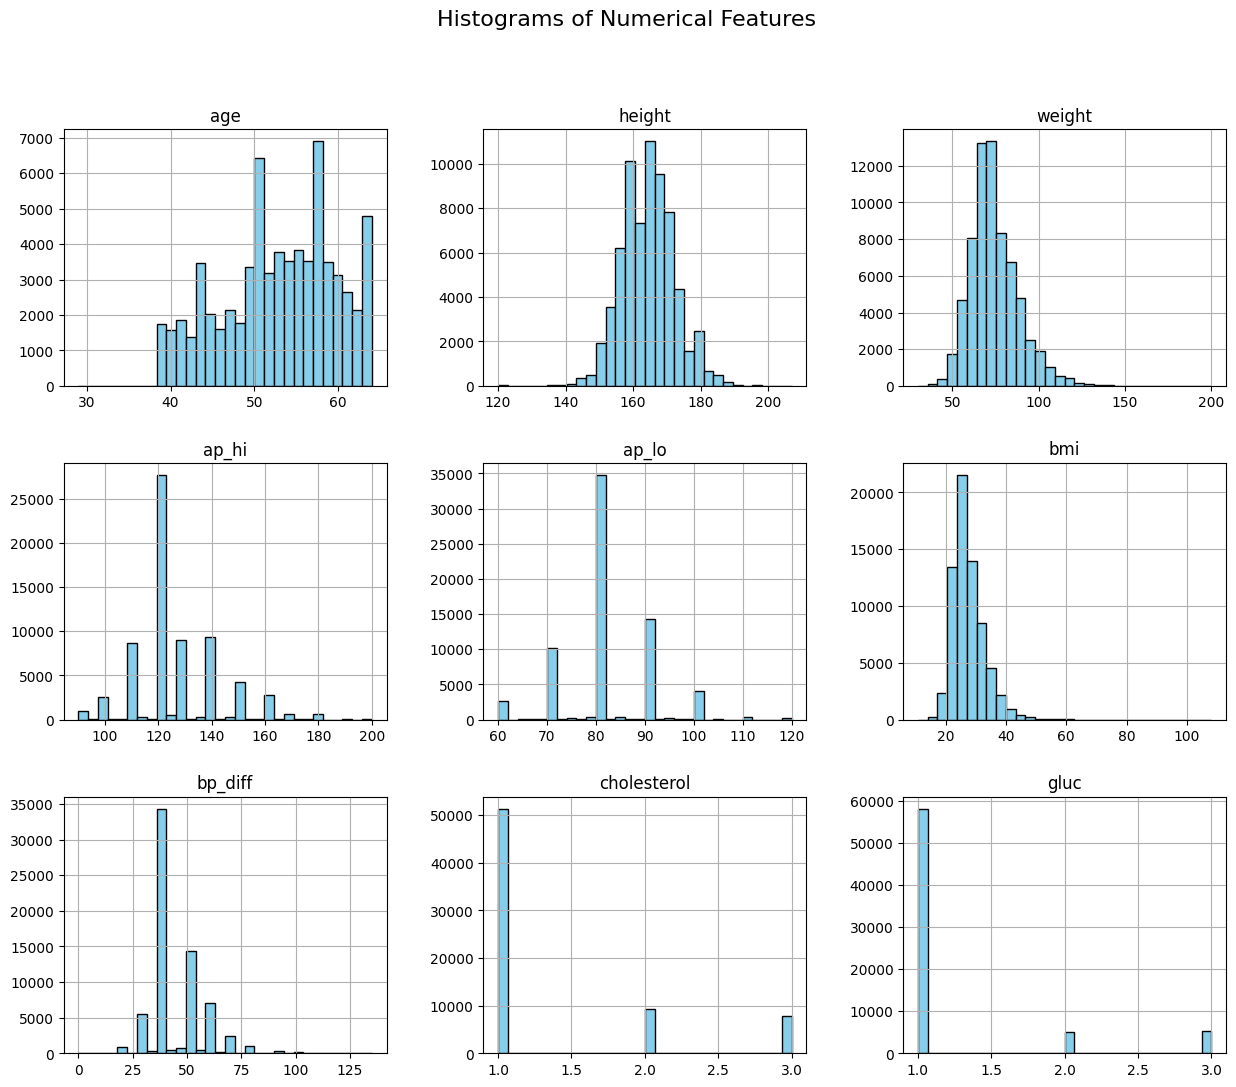

In [ ]:
#Distribution / Histograms
print("\nPlotting Histograms for numerical variables...")
numeric_cols = ["age", "height", "weight", "ap_hi", "ap_lo", "bmi", "bp_diff", "cholesterol", "gluc"]
data[numeric_cols].hist(figsize=(15, 12), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()



Countplot: Gender vs Cardiovascular Disease


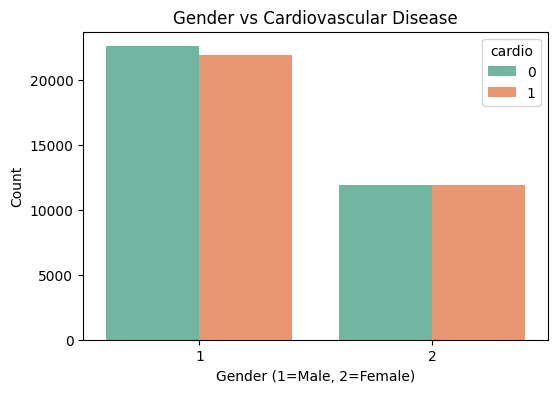

In [ ]:
#  Countplots: gender vs cardio
print("\nCountplot: Gender vs Cardiovascular Disease")
plt.figure(figsize=(6,4))
sns.countplot(x="gender", hue="cardio", data=data, palette="Set2")
plt.title("Gender vs Cardiovascular Disease")
plt.xlabel("Gender (1=Male, 2=Female)")
plt.ylabel("Count")
plt.show()



Countplot: Cholesterol vs Cardiovascular Disease


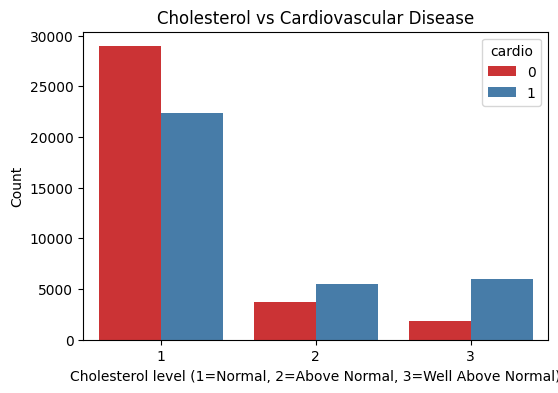

In [ ]:
#  Countplots: cholesterol vs cardio
print("\nCountplot: Cholesterol vs Cardiovascular Disease")
plt.figure(figsize=(6,4))
sns.countplot(x="cholesterol", hue="cardio", data=data, palette="Set1")
plt.title("Cholesterol vs Cardiovascular Disease")
plt.xlabel("Cholesterol level (1=Normal, 2=Above Normal, 3=Well Above Normal)")
plt.ylabel("Count")
plt.show()



Boxplots: Blood Pressure vs Cardiovascular Disease


/tmp/ipython-input-2123652568.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cardio", y="ap_hi", data=data, palette="coolwarm")


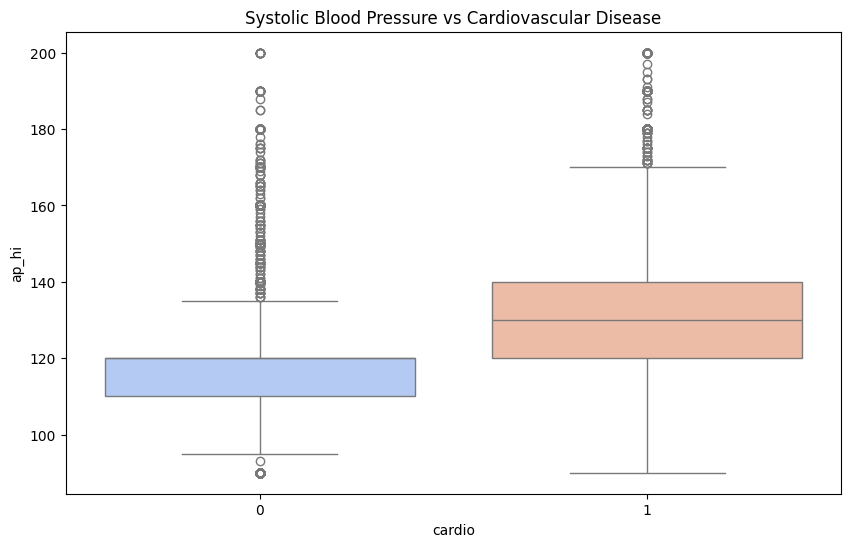

In [ ]:

#  Boxplots: blood pressure vs cardio
print("\nBoxplots: Blood Pressure vs Cardiovascular Disease")
plt.figure(figsize=(10,6))
sns.boxplot(x="cardio", y="ap_hi", data=data, palette="coolwarm")
plt.title("Systolic Blood Pressure vs Cardiovascular Disease")
plt.show()


/tmp/ipython-input-2207713572.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cardio", y="ap_lo", data=data, palette="coolwarm")


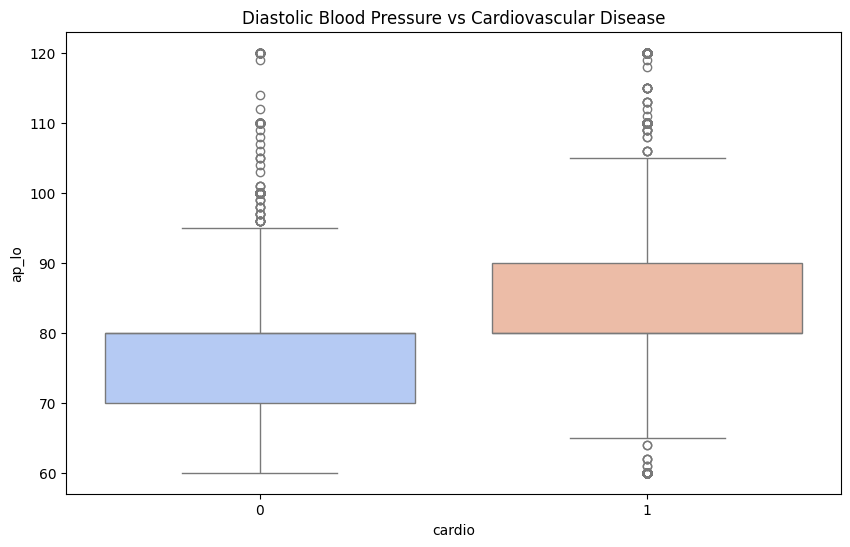

In [ ]:

plt.figure(figsize=(10,6))
sns.boxplot(x="cardio", y="ap_lo", data=data, palette="coolwarm")
plt.title("Diastolic Blood Pressure vs Cardiovascular Disease")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Placeholder code to create a sample DataFrame - REPLACE THIS with your actual data loading
data_frame = {
    'ap_hi': np.random.rand(100) * 100 + 90,
    'ap_lo': np.random.rand(100) * 60 + 60,
    'cholesterol': np.random.randint(1, 4, 100),
    'gluc': np.random.randint(1, 4, 100),
    'smoke': np.random.randint(0, 2, 100),
    'alco': np.random.randint(0, 2, 100),
    'active': np.random.randint(0, 2, 100),
    'cardio': np.random.randint(0, 2, 100)
}
df = pd.DataFrame(data_frame)

print("--- 3. Correlation Analysis ---")

--- 3. Correlation Analysis ---


In [ ]:
# Compute the correlation matrix
print("Computing the correlation matrix...")
correlation_matrix = df.corr()

Computing the correlation matrix...


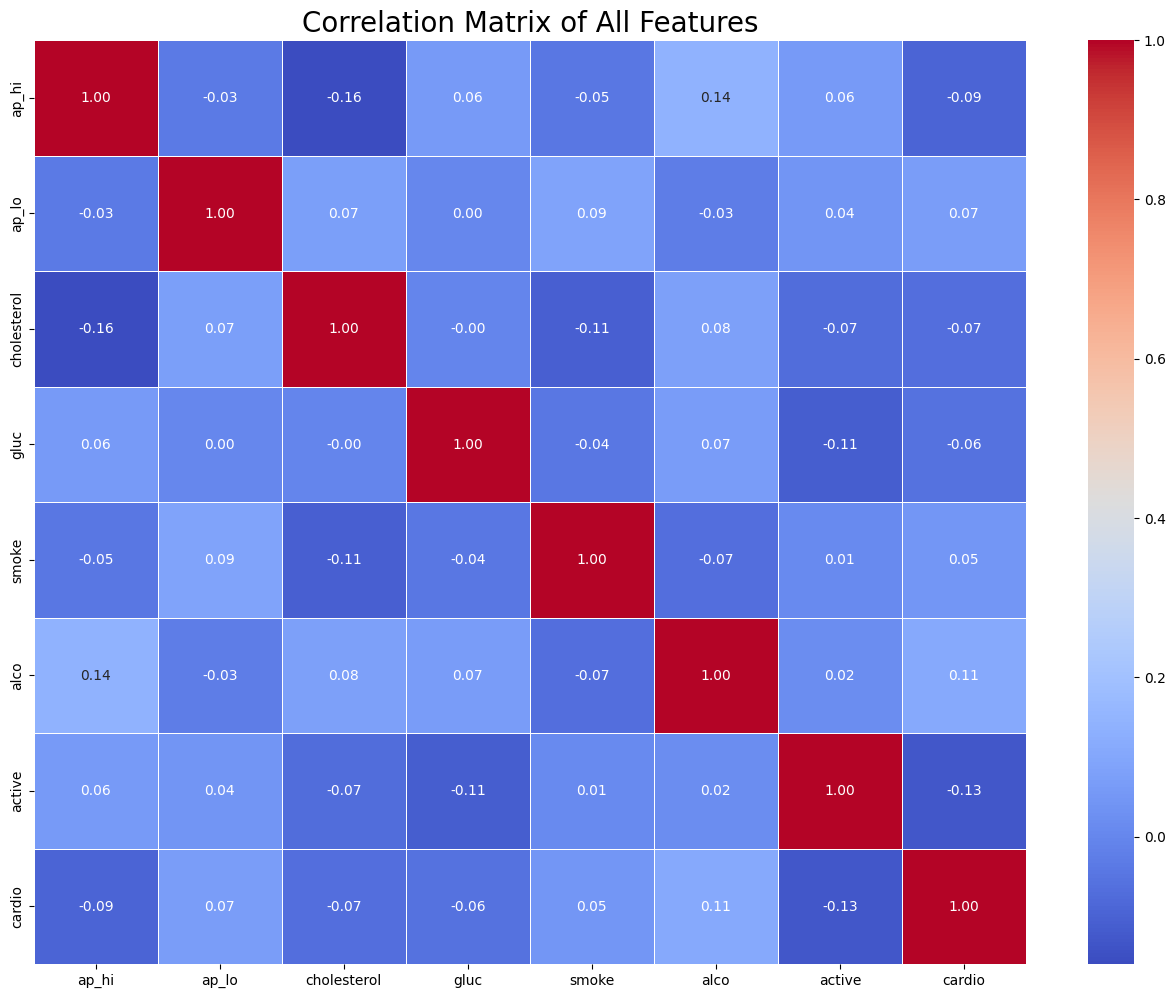

In [ ]:
# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of All Features', fontsize=20)
plt.show()

In [ ]:
# Analyze correlation with the target variable 'cardio'
print("\nFeatures most correlated with 'cardio' (target variable):")
cardio_corr = correlation_matrix['cardio'].sort_values(ascending=False)
print(cardio_corr)


Features most correlated with 'cardio' (target variable):
cardio         1.000000
alco           0.108948
ap_lo          0.070631
smoke          0.046699
gluc          -0.057245
cholesterol   -0.067324
ap_hi         -0.092940
active        -0.130963
Name: cardio, dtype: float64


In [ ]:
# Discuss multicollinearity, which is when two independent variables are highly correlated.
# A common example is the relationship between 'ap_hi' and 'ap_lo'.
ap_hi_lo_corr = correlation_matrix.loc['ap_hi', 'ap_lo']
print(f"\nExample of Multicollinearity: The correlation between 'ap_hi' and 'ap_lo' is {ap_hi_lo_corr:.2f}.")
if abs(ap_hi_lo_corr) > 0.7:
    print("This high correlation suggests potential multicollinearity. For some models, you might consider removing one of these features to avoid issues.")

print("\nCorrelation analysis complete. The heatmap provides a clear view of the relationships.")


Example of Multicollinearity: The correlation between 'ap_hi' and 'ap_lo' is -0.03.

Correlation analysis complete. The heatmap provides a clear view of the relationships.


In [ ]:
from sklearn.model_selection import train_test_split
X=data.drop("cardio",axis=1)
y=data["cardio"]
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

models={
    "Logistic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "SVM":SVC(),
    "KNN":KNeighborsClassifier(),
    "GaussianNB":GaussianNB()
}

results = []
for name,model in models.items():
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"])
results_df = results_df.sort_values(by="F1", ascending=False).reset_index(drop=True)

print("\n=== Model Performance Comparison ===")
print(results_df)


=== Model Performance Comparison ===
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
0                  SVM  0.730983   0.763755  0.658464  0.707212       NaN
1  Logistic Regression  0.727399   0.754253  0.663801  0.706142  0.793366
2        Random Forest  0.704067   0.704980  0.688260  0.696520  0.765520
3                  KNN  0.694046   0.695918  0.674770  0.685181  0.746622
4           GaussianNB  0.714160   0.766129  0.605544  0.676436  0.781440
5        Decision Tree  0.636556   0.634601  0.620961  0.627707  0.637143


In [ ]:
# according to the data that is received after testing all the models
#Linear regression works the best
from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report
final_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]



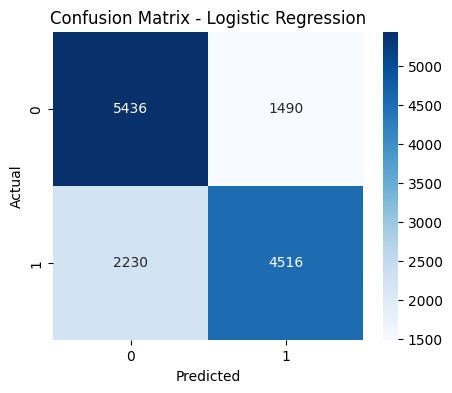


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6926
           1       0.75      0.67      0.71      6746

    accuracy                           0.73     13672
   macro avg       0.73      0.73      0.73     13672
weighted avg       0.73      0.73      0.73     13672



In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

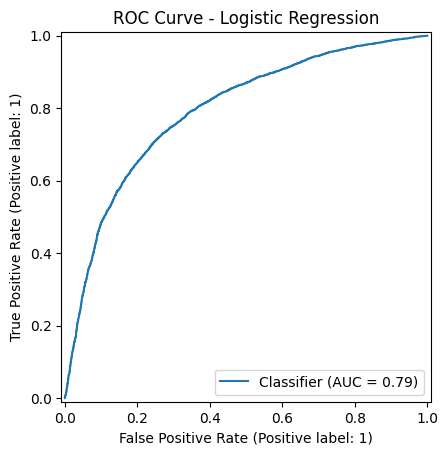

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [ ]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": final_model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\nTop Predictive Features (Logistic Regression):")
print(feature_importance.head(10))


Top Predictive Features (Logistic Regression):
        Feature  Coefficient
4         ap_hi     0.448875
5         ap_lo     0.384472
0           age     0.345307
6   cholesterol     0.332826
12      bp_diff     0.332344
10       active    -0.101014
3        weight     0.079926
11          bmi     0.067354
7          gluc    -0.056873
9          alco    -0.047703
